## *** RESTORE FROM BACKUP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/ECE-653/Dataset.zip . && unzip Dataset.zip && rm Dataset.zip

## **Set locale to UTF-8**

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

## **Import Packages**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from google.colab import drive

import os
import time
import random

## **Set to use CUDA**

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## **Class mapping**

In [ ]:

class_to_idx = {
  'Speed Limit 10': 0,
  'Speed Limit 20': 1,
  'Speed Limit 30': 2,
  'Speed Limit 40': 3,
  'Speed Limit 50': 4,
  'Speed Limit 60': 5,
  'Speed Limit 70': 6,
  'Speed Limit 80': 7,
  'Speed Limit 90': 8,
  'Speed Limit 100': 9,
  'Speed Limit 110': 10,
  'Speed Limit 120': 11,
  'Stop': 12
}

class_names = {
    0: 'Speed Limit 10',
    1: 'Speed Limit 20',
    2: 'Speed Limit 30',
    3: 'Speed Limit 40',
    4: 'Speed Limit 50',
    5: 'Speed Limit 60',
    6: 'Speed Limit 70',
    7: 'Speed Limit 80',
    8: 'Speed Limit 90',
    9: 'Speed Limit 100',
    10: 'Speed Limit 110',
    11: 'Speed Limit 120',
    12: 'Stop'
}

## **SET PARPAMS**

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 100
NUM_EPOCHS = 15
NUM_CLASSES = 13

# IMAGE_SIZE = 32
# BATCH_SIZE = 32
# NUM_EPOCHS = 20
# NUM_CLASSES = 13

## **Implement Normalization(Transform)**

In [ ]:
# Transform for input preprocessing

def get_transform(is_training=True):
    base_transform = [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Bilinear interpolation
        transforms.ToTensor()
    ]

    if is_training:
        # Add augmentations for training only
        train_transform = [
            # Tilt/Rotation: randomly rotate image within a range
            transforms.RandomRotation(degrees=15),

            # Blur: apply Gaussian blur with random kernel size
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
            ], p=0.3),

            # Illumination changes: brightness, contrast, saturation, hue
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),

            # You can add more augmentations here
            transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.3),  # Translation
        ]
        # Insert augmentations before the base transforms
        transform = transforms.Compose(train_transform + base_transform)
    else:
        # No augmentation for validation/testing
        transform = transforms.Compose(base_transform)

    return transform

## **Define Loader**

In [ ]:
# Custom Dataset for Traffic Signs with reduced image size
class TrafficSignDataset(Dataset):
    def __init__(self, data_type, root_dir, transform=None, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            target_size (tuple): Target size for images (defaults to IMAGE_SIZE x IMAGE_SIZE)
        """
        self.data_type = data_type
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Find all image files and their labels
        self.samples = []

        data_path = "/content/Dataset"
        with open(os.path.join(data_path, self.data_type, '_annotations.csv'), 'r') as fh:
          lines = fh.readlines()
          for line in lines:
            if line.strip() != '' and not line.startswith('filename'):
              splitted = line.split(',')
              filename = splitted[0]
              label = splitted[3]
              self.samples.append((
                  os.path.join(self.root_dir, filename),
                  class_to_idx[label]
              ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')
        image = image.resize(self.target_size, Image.BILINEAR)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


## **Define our classifier model**

In [ ]:
class SimpleTrafficSignNet(nn.Module):
    def __init__(self, num_classes=13):
        super(SimpleTrafficSignNet, self).__init__()

        # Layer definitions
        self.conv1 = nn.Conv2d(3, IMAGE_SIZE, kernel_size=5, padding=2)  # 32x32x32
        self.dropout1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(IMAGE_SIZE, IMAGE_SIZE*2, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(IMAGE_SIZE*2, IMAGE_SIZE*4, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout(0.3)

        # This is the key part - we need separate pooling layers with specific sizes
        # to match the Keras model architecture exactly
        self.pool4 = nn.MaxPool2d(kernel_size=8, stride=8)  # For path1: 32x32x32 -> 4x4x32 = 512
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)  # For path2: 8x8x64 -> 4x4x64 = 1024

        self.dropout4 = nn.Dropout(0.5)

        # Total concatenated features: 512 + 1024 + 2048 = 3584
        #self.fc1 = nn.Linear(3584, 1024)
        self.fc1 = nn.Linear(28672, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Conv1 path
        x1 = self.conv1(x)                # 32x32x32
        x1 = F.relu(x1)
        x1 = self.dropout1(x1)
        x1_pooled = self.pool(x1)         # 16x16x32

        # Conv2 path
        x2 = self.conv2(x1_pooled)        # 16x16x64
        x2 = F.relu(x2)
        x2 = self.dropout2(x2)
        x2_pooled = self.pool(x2)         # 8x8x64

        # Conv3 path
        x3 = self.conv3(x2_pooled)        # 8x8x128
        x3 = F.relu(x3)
        x3 = self.dropout3(x3)
        x3_pooled = self.pool(x3)         # 4x4x128 = 2048 flattened

        # Multiscale pooling paths (matching Keras exactly)
        # Path 1: pool4 directly on conv1 output (after dropout)
        path1 = self.pool4(x1)            # 4x4x32 = 512 flattened

        # Path 2: pool5 on the output of pool2
        path2 = self.pool5(x2_pooled)     # 4x4x64 = 1024 flattened

        # Path 3: already at the right size from pool3
        path3 = x3_pooled                 # 4x4x128 = 2048 flattened

        # Flatten and concatenate
        flat1 = torch.flatten(path1, 1)   # 512
        flat2 = torch.flatten(path2, 1)   # 1024
        flat3 = torch.flatten(path3, 1)   # 2048

        merged = torch.cat([flat1, flat2, flat3], dim=1)  # 3584

        # Dense layers
        dense1 = self.fc1(merged)         # 1024
        dense1 = F.relu(dense1)
        dense1 = self.dropout4(dense1)

        # Output layer (logits, no activation)
        output = self.fc2(dense1)         # num_classes

        return output

## **(Training) Start training our model!**

Training Configuration:
----------------------
Image Size: 64x64
Batch Size: 100
Epochs: 20
Classes: 13
Learning Rate: 0.0001
Device: cuda
----------------------

Dataset Information:
-------------------
Training samples: 6725
Validation samples: 1584
Testing samples: 1205
Class mapping: {'Speed Limit 10': 0, 'Speed Limit 20': 1, 'Speed Limit 30': 2, 'Speed Limit 40': 3, 'Speed Limit 50': 4, 'Speed Limit 60': 5, 'Speed Limit 70': 6, 'Speed Limit 80': 7, 'Speed Limit 90': 8, 'Speed Limit 100': 9, 'Speed Limit 110': 10, 'Speed Limit 120': 11, 'Stop': 12}
-------------------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training...
Model Architecture:
SimpleTrafficSignNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout3): Dropout(p=0.3, inplace=False)
  (pool4): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=28672, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=13, bias=True)
)
Total parameters: 30403725
Trainable parameters: 30403725
--------------------------------------------------
Epoch 1/20
---------------------

Epoch 1/20 [Train]:   4%|▍         | 3/68 [00:02<00:42,  1.55it/s, acc=0.2000, loss=2.4390]

  Batch 0/68: Loss: 2.5622, Acc: 0.1000


Epoch 1/20 [Train]:  16%|█▌        | 11/68 [00:03<00:08,  6.69it/s, acc=0.2400, loss=2.3043]

  Batch 10/68: Loss: 2.3481, Acc: 0.2300


Epoch 1/20 [Train]:  34%|███▍      | 23/68 [00:05<00:11,  4.01it/s, acc=0.2900, loss=2.2390]

  Batch 20/68: Loss: 2.1421, Acc: 0.2600


Epoch 1/20 [Train]:  46%|████▌     | 31/68 [00:08<00:09,  3.95it/s, acc=0.2700, loss=1.8825]

  Batch 30/68: Loss: 2.0301, Acc: 0.2400


Epoch 1/20 [Train]:  62%|██████▏   | 42/68 [00:10<00:05,  4.76it/s, acc=0.2900, loss=1.9056]

  Batch 40/68: Loss: 1.8234, Acc: 0.4000


Epoch 1/20 [Train]:  76%|███████▋  | 52/68 [00:11<00:02,  6.44it/s, acc=0.4800, loss=1.6288]

  Batch 50/68: Loss: 1.6507, Acc: 0.4200


Epoch 1/20 [Train]:  90%|████████▉ | 61/68 [00:13<00:01,  6.18it/s, acc=0.4400, loss=1.6136]

  Batch 60/68: Loss: 1.6136, Acc: 0.4400


Epoch 1/20 [Train]: 100%|██████████| 68/68 [00:14<00:00,  4.82it/s, acc=0.8400, loss=1.0416]


Train Loss: 1.9595 Acc: 0.3313


Epoch 1/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.86it/s, acc=0.6190, loss=1.3947]


Val Loss: 1.5236 Acc: 0.5183
New best model saved! Validation accuracy: 0.5183
Epoch 2/20
------------------------------


Epoch 2/20 [Train]:   3%|▎         | 2/68 [00:00<00:26,  2.50it/s, acc=0.5700, loss=1.2306]

  Batch 0/68: Loss: 1.3250, Acc: 0.5400


Epoch 2/20 [Train]:  18%|█▊        | 12/68 [00:02<00:07,  7.10it/s, acc=0.7600, loss=1.0523]

  Batch 10/68: Loss: 1.0953, Acc: 0.6600


Epoch 2/20 [Train]:  32%|███▏      | 22/68 [00:04<00:08,  5.48it/s, acc=0.7300, loss=0.8390]

  Batch 20/68: Loss: 1.0258, Acc: 0.6500


Epoch 2/20 [Train]:  47%|████▋     | 32/68 [00:05<00:05,  6.92it/s, acc=0.8100, loss=0.6113]

  Batch 30/68: Loss: 0.6506, Acc: 0.8100


Epoch 2/20 [Train]:  60%|██████    | 41/68 [00:07<00:03,  7.66it/s, acc=0.8400, loss=0.6010]

  Batch 40/68: Loss: 0.6570, Acc: 0.8100


Epoch 2/20 [Train]:  78%|███████▊  | 53/68 [00:08<00:01,  8.53it/s, acc=0.8400, loss=0.4893]

  Batch 50/68: Loss: 0.5723, Acc: 0.8100


Epoch 2/20 [Train]:  91%|█████████ | 62/68 [00:09<00:00,  9.31it/s, acc=0.8900, loss=0.3906]

  Batch 60/68: Loss: 0.4565, Acc: 0.9300


Epoch 2/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.57it/s, acc=0.8000, loss=0.4773]


Train Loss: 0.7293 Acc: 0.7816


Epoch 2/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.87it/s, acc=0.8929, loss=0.4991]


Val Loss: 0.4656 Acc: 0.9249
New best model saved! Validation accuracy: 0.9249
Epoch 3/20
------------------------------


Epoch 3/20 [Train]:   3%|▎         | 2/68 [00:01<00:31,  2.09it/s, acc=0.8400, loss=0.6127]

  Batch 0/68: Loss: 0.4347, Acc: 0.8400


Epoch 3/20 [Train]:  18%|█▊        | 12/68 [00:02<00:08,  6.43it/s, acc=0.8700, loss=0.4205]

  Batch 10/68: Loss: 0.3864, Acc: 0.8700


Epoch 3/20 [Train]:  34%|███▍      | 23/68 [00:05<00:08,  5.17it/s, acc=0.9200, loss=0.3020]

  Batch 20/68: Loss: 0.4918, Acc: 0.8900


Epoch 3/20 [Train]:  46%|████▌     | 31/68 [00:06<00:06,  5.65it/s, acc=0.8900, loss=0.3279]

  Batch 30/68: Loss: 0.2562, Acc: 0.9400


Epoch 3/20 [Train]:  63%|██████▎   | 43/68 [00:08<00:03,  8.16it/s, acc=0.9300, loss=0.2069]

  Batch 40/68: Loss: 0.3056, Acc: 0.9000


Epoch 3/20 [Train]:  75%|███████▌  | 51/68 [00:09<00:01,  8.91it/s, acc=0.9300, loss=0.2858]

  Batch 50/68: Loss: 0.2036, Acc: 0.9500


Epoch 3/20 [Train]:  93%|█████████▎| 63/68 [00:10<00:00,  9.54it/s, acc=0.9400, loss=0.2350]

  Batch 60/68: Loss: 0.2252, Acc: 0.9300


Epoch 3/20 [Train]: 100%|██████████| 68/68 [00:11<00:00,  6.11it/s, acc=1.0000, loss=0.0756]


Train Loss: 0.2932 Acc: 0.9216


Epoch 3/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.85it/s, acc=0.9524, loss=0.3649]


Val Loss: 0.3294 Acc: 0.9444
New best model saved! Validation accuracy: 0.9444
Epoch 4/20
------------------------------


Epoch 4/20 [Train]:   3%|▎         | 2/68 [00:00<00:21,  3.09it/s, acc=0.9500, loss=0.1787]

  Batch 0/68: Loss: 0.1946, Acc: 0.9600


Epoch 4/20 [Train]:  18%|█▊        | 12/68 [00:01<00:06,  9.13it/s, acc=0.9400, loss=0.1847]

  Batch 10/68: Loss: 0.1033, Acc: 0.9800


Epoch 4/20 [Train]:  29%|██▉       | 20/68 [00:02<00:05,  8.94it/s, acc=0.9800, loss=0.0974]

  Batch 20/68: Loss: 0.0974, Acc: 0.9800


Epoch 4/20 [Train]:  47%|████▋     | 32/68 [00:04<00:05,  6.40it/s, acc=0.9500, loss=0.1552]

  Batch 30/68: Loss: 0.1206, Acc: 0.9600


Epoch 4/20 [Train]:  60%|██████    | 41/68 [00:06<00:04,  6.01it/s, acc=0.9700, loss=0.1572]

  Batch 40/68: Loss: 0.1572, Acc: 0.9700


Epoch 4/20 [Train]:  74%|███████▎  | 50/68 [00:08<00:02,  6.38it/s, acc=0.9700, loss=0.1325]

  Batch 50/68: Loss: 0.1325, Acc: 0.9700


Epoch 4/20 [Train]:  88%|████████▊ | 60/68 [00:09<00:01,  7.81it/s, acc=0.9900, loss=0.0703]

  Batch 60/68: Loss: 0.0703, Acc: 0.9900


Epoch 4/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.70it/s, acc=1.0000, loss=0.0168]


Train Loss: 0.1641 Acc: 0.9609


Epoch 4/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.77it/s, acc=0.9643, loss=0.2749]


Val Loss: 0.2412 Acc: 0.9545
New best model saved! Validation accuracy: 0.9545
Epoch 5/20
------------------------------


Epoch 5/20 [Train]:   3%|▎         | 2/68 [00:00<00:24,  2.70it/s, acc=0.9600, loss=0.1556]

  Batch 0/68: Loss: 0.2654, Acc: 0.9600


Epoch 5/20 [Train]:  16%|█▌        | 11/68 [00:02<00:07,  7.38it/s, acc=0.9800, loss=0.0981]

  Batch 10/68: Loss: 0.1169, Acc: 0.9900


Epoch 5/20 [Train]:  34%|███▍      | 23/68 [00:03<00:05,  8.42it/s, acc=0.9800, loss=0.0985]

  Batch 20/68: Loss: 0.1485, Acc: 0.9600


Epoch 5/20 [Train]:  46%|████▌     | 31/68 [00:04<00:03,  9.27it/s, acc=0.9500, loss=0.4578]

  Batch 30/68: Loss: 0.0691, Acc: 0.9900


Epoch 5/20 [Train]:  62%|██████▏   | 42/68 [00:06<00:04,  5.73it/s, acc=0.9700, loss=0.0996]

  Batch 40/68: Loss: 0.0949, Acc: 0.9800


Epoch 5/20 [Train]:  75%|███████▌  | 51/68 [00:08<00:03,  5.58it/s, acc=0.9900, loss=0.0657]

  Batch 50/68: Loss: 0.1214, Acc: 0.9600


Epoch 5/20 [Train]:  93%|█████████▎| 63/68 [00:09<00:00,  7.57it/s, acc=0.9600, loss=0.1220]

  Batch 60/68: Loss: 0.0518, Acc: 0.9900


Epoch 5/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.61it/s, acc=0.9600, loss=0.2700]


Train Loss: 0.1227 Acc: 0.9717


Epoch 5/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.83it/s, acc=0.9524, loss=0.2881]


Val Loss: 0.2416 Acc: 0.9571
New best model saved! Validation accuracy: 0.9571
Epoch 6/20
------------------------------


Epoch 6/20 [Train]:   1%|▏         | 1/68 [00:00<00:46,  1.44it/s, acc=0.9900, loss=0.0982]

  Batch 0/68: Loss: 0.0907, Acc: 0.9800


Epoch 6/20 [Train]:  16%|█▌        | 11/68 [00:01<00:07,  8.01it/s, acc=0.9900, loss=0.0482]

  Batch 10/68: Loss: 0.0751, Acc: 0.9900


Epoch 6/20 [Train]:  34%|███▍      | 23/68 [00:03<00:05,  8.46it/s, acc=0.9600, loss=0.1200]

  Batch 20/68: Loss: 0.0522, Acc: 0.9800


Epoch 6/20 [Train]:  46%|████▌     | 31/68 [00:04<00:04,  8.48it/s, acc=0.9700, loss=0.0943]

  Batch 30/68: Loss: 0.1907, Acc: 0.9700


Epoch 6/20 [Train]:  63%|██████▎   | 43/68 [00:05<00:03,  7.76it/s, acc=0.9800, loss=0.0891]

  Batch 40/68: Loss: 0.1213, Acc: 0.9700


Epoch 6/20 [Train]:  75%|███████▌  | 51/68 [00:07<00:02,  7.49it/s, acc=0.9900, loss=0.0684]

  Batch 50/68: Loss: 0.1634, Acc: 0.9700


Epoch 6/20 [Train]:  93%|█████████▎| 63/68 [00:09<00:00,  6.08it/s, acc=0.9400, loss=0.1332]

  Batch 60/68: Loss: 0.1553, Acc: 0.9700


Epoch 6/20 [Train]: 100%|██████████| 68/68 [00:09<00:00,  6.84it/s, acc=1.0000, loss=0.0218]


Train Loss: 0.1134 Acc: 0.9671


Epoch 6/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s, acc=0.9762, loss=0.2330]


Val Loss: 0.1990 Acc: 0.9691
New best model saved! Validation accuracy: 0.9691
Epoch 7/20
------------------------------


Epoch 7/20 [Train]:   3%|▎         | 2/68 [00:00<00:22,  2.98it/s, acc=0.9800, loss=0.1255]

  Batch 0/68: Loss: 0.1106, Acc: 0.9600


Epoch 7/20 [Train]:  19%|█▉        | 13/68 [00:02<00:06,  7.97it/s, acc=0.9800, loss=0.0789]

  Batch 10/68: Loss: 0.0353, Acc: 1.0000


Epoch 7/20 [Train]:  29%|██▉       | 20/68 [00:03<00:06,  7.84it/s, acc=0.9800, loss=0.0705]

  Batch 20/68: Loss: 0.0705, Acc: 0.9800


Epoch 7/20 [Train]:  47%|████▋     | 32/68 [00:04<00:04,  8.51it/s, acc=0.9900, loss=0.0604]

  Batch 30/68: Loss: 0.0817, Acc: 0.9800


Epoch 7/20 [Train]:  59%|█████▉    | 40/68 [00:05<00:03,  8.00it/s, acc=0.9800, loss=0.0595]

  Batch 40/68: Loss: 0.0595, Acc: 0.9800


Epoch 7/20 [Train]:  76%|███████▋  | 52/68 [00:07<00:01,  8.92it/s, acc=0.9900, loss=0.0795]

  Batch 50/68: Loss: 0.0878, Acc: 0.9900


Epoch 7/20 [Train]:  88%|████████▊ | 60/68 [00:08<00:00,  8.27it/s, acc=0.9900, loss=0.0242]

  Batch 60/68: Loss: 0.0242, Acc: 0.9900


Epoch 7/20 [Train]: 100%|██████████| 68/68 [00:09<00:00,  7.41it/s, acc=0.9200, loss=0.1166]


Train Loss: 0.0825 Acc: 0.9796


Epoch 7/20 [Val]: 100%|██████████| 16/16 [00:03<00:00,  5.11it/s, acc=0.9524, loss=0.2253]


Val Loss: 0.2073 Acc: 0.9590
Epoch 8/20
------------------------------


Epoch 8/20 [Train]:   3%|▎         | 2/68 [00:00<00:21,  3.09it/s, acc=0.9700, loss=0.0855]

  Batch 0/68: Loss: 0.1311, Acc: 0.9700


Epoch 8/20 [Train]:  16%|█▌        | 11/68 [00:01<00:06,  8.22it/s, acc=0.9700, loss=0.0766]

  Batch 10/68: Loss: 0.0892, Acc: 0.9800


Epoch 8/20 [Train]:  32%|███▏      | 22/68 [00:03<00:05,  7.90it/s, acc=0.9800, loss=0.0872]

  Batch 20/68: Loss: 0.0510, Acc: 0.9900


Epoch 8/20 [Train]:  47%|████▋     | 32/68 [00:04<00:04,  8.80it/s, acc=0.9800, loss=0.0933]

  Batch 30/68: Loss: 0.0513, Acc: 0.9900


Epoch 8/20 [Train]:  62%|██████▏   | 42/68 [00:05<00:02,  9.70it/s, acc=0.9800, loss=0.0694]

  Batch 40/68: Loss: 0.1164, Acc: 0.9700


Epoch 8/20 [Train]:  76%|███████▋  | 52/68 [00:06<00:02,  7.47it/s, acc=0.9700, loss=0.1340]

  Batch 50/68: Loss: 0.1065, Acc: 0.9600


Epoch 8/20 [Train]:  91%|█████████ | 62/68 [00:07<00:00,  9.44it/s, acc=0.9800, loss=0.0675]

  Batch 60/68: Loss: 0.0848, Acc: 0.9800


Epoch 8/20 [Train]: 100%|██████████| 68/68 [00:08<00:00,  7.98it/s, acc=0.9600, loss=0.0568]


Train Loss: 0.0768 Acc: 0.9805


Epoch 8/20 [Val]: 100%|██████████| 16/16 [00:03<00:00,  4.81it/s, acc=0.9643, loss=0.2364]


Val Loss: 0.1959 Acc: 0.9634
Epoch 9/20
------------------------------


Epoch 9/20 [Train]:   3%|▎         | 2/68 [00:01<00:38,  1.70it/s, acc=0.9800, loss=0.0878]

  Batch 0/68: Loss: 0.0548, Acc: 0.9900


Epoch 9/20 [Train]:  16%|█▌        | 11/68 [00:02<00:07,  7.63it/s, acc=0.9800, loss=0.0666]

  Batch 10/68: Loss: 0.0773, Acc: 0.9800


Epoch 9/20 [Train]:  34%|███▍      | 23/68 [00:03<00:05,  8.92it/s, acc=0.9800, loss=0.0627]

  Batch 20/68: Loss: 0.1134, Acc: 0.9800


Epoch 9/20 [Train]:  49%|████▊     | 33/68 [00:05<00:04,  8.53it/s, acc=0.9700, loss=0.0963]

  Batch 30/68: Loss: 0.1288, Acc: 0.9600


Epoch 9/20 [Train]:  60%|██████    | 41/68 [00:06<00:03,  8.34it/s, acc=0.9900, loss=0.0749]

  Batch 40/68: Loss: 0.0585, Acc: 0.9900


Epoch 9/20 [Train]:  78%|███████▊  | 53/68 [00:07<00:01,  9.71it/s, acc=0.9900, loss=0.0375]

  Batch 50/68: Loss: 0.0224, Acc: 1.0000


Epoch 9/20 [Train]:  90%|████████▉ | 61/68 [00:08<00:00,  8.48it/s, acc=1.0000, loss=0.0205]

  Batch 60/68: Loss: 0.0366, Acc: 0.9900


Epoch 9/20 [Train]: 100%|██████████| 68/68 [00:09<00:00,  7.32it/s, acc=1.0000, loss=0.0274]


Train Loss: 0.0618 Acc: 0.9826


Epoch 9/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.79it/s, acc=0.9762, loss=0.2039]


Val Loss: 0.1777 Acc: 0.9634
Epoch 10/20
------------------------------


Epoch 10/20 [Train]:   3%|▎         | 2/68 [00:01<00:29,  2.24it/s, acc=0.9800, loss=0.0700]

  Batch 0/68: Loss: 0.0386, Acc: 0.9900


Epoch 10/20 [Train]:  18%|█▊        | 12/68 [00:02<00:09,  5.81it/s, acc=0.9800, loss=0.0385]

  Batch 10/68: Loss: 0.0756, Acc: 0.9600


Epoch 10/20 [Train]:  34%|███▍      | 23/68 [00:04<00:07,  6.18it/s, acc=0.9800, loss=0.0393]

  Batch 20/68: Loss: 0.0512, Acc: 0.9800


Epoch 10/20 [Train]:  46%|████▌     | 31/68 [00:05<00:04,  8.58it/s, acc=1.0000, loss=0.0198]

  Batch 30/68: Loss: 0.1521, Acc: 0.9500


Epoch 10/20 [Train]:  63%|██████▎   | 43/68 [00:07<00:02,  8.72it/s, acc=1.0000, loss=0.0174]

  Batch 40/68: Loss: 0.0146, Acc: 1.0000


Epoch 10/20 [Train]:  78%|███████▊  | 53/68 [00:08<00:01,  9.16it/s, acc=0.9900, loss=0.0435]

  Batch 50/68: Loss: 0.0158, Acc: 1.0000


Epoch 10/20 [Train]:  90%|████████▉ | 61/68 [00:09<00:00,  7.96it/s, acc=1.0000, loss=0.0196]

  Batch 60/68: Loss: 0.0265, Acc: 1.0000


Epoch 10/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.60it/s, acc=1.0000, loss=0.0259]


Train Loss: 0.0562 Acc: 0.9839


Epoch 10/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.84it/s, acc=0.9524, loss=0.2578]


Val Loss: 0.1824 Acc: 0.9722
New best model saved! Validation accuracy: 0.9722
Epoch 11/20
------------------------------


Epoch 11/20 [Train]:   3%|▎         | 2/68 [00:00<00:22,  2.91it/s, acc=1.0000, loss=0.0320]

  Batch 0/68: Loss: 0.0683, Acc: 0.9800


Epoch 11/20 [Train]:  16%|█▌        | 11/68 [00:01<00:07,  7.98it/s, acc=0.9500, loss=0.0901]

  Batch 10/68: Loss: 0.0167, Acc: 1.0000


Epoch 11/20 [Train]:  29%|██▉       | 20/68 [00:03<00:08,  5.98it/s, acc=0.9900, loss=0.0316]

  Batch 20/68: Loss: 0.0316, Acc: 0.9900


Epoch 11/20 [Train]:  47%|████▋     | 32/68 [00:06<00:06,  5.42it/s, acc=0.9800, loss=0.0574]

  Batch 30/68: Loss: 0.0565, Acc: 0.9800


Epoch 11/20 [Train]:  59%|█████▉    | 40/68 [00:06<00:03,  8.18it/s, acc=0.9700, loss=0.0659]

  Batch 40/68: Loss: 0.0659, Acc: 0.9700


Epoch 11/20 [Train]:  76%|███████▋  | 52/68 [00:08<00:01,  8.67it/s, acc=0.9700, loss=0.0645]

  Batch 50/68: Loss: 0.0276, Acc: 0.9900


Epoch 11/20 [Train]:  88%|████████▊ | 60/68 [00:09<00:01,  7.95it/s, acc=0.9600, loss=0.0873]

  Batch 60/68: Loss: 0.0873, Acc: 0.9600


Epoch 11/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.68it/s, acc=1.0000, loss=0.0383]


Train Loss: 0.0528 Acc: 0.9839


Epoch 11/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.75it/s, acc=0.9643, loss=0.2483]


Val Loss: 0.1861 Acc: 0.9659
Epoch 12/20
------------------------------


Epoch 12/20 [Train]:   4%|▍         | 3/68 [00:00<00:15,  4.19it/s, acc=0.9900, loss=0.0395]

  Batch 0/68: Loss: 0.0423, Acc: 0.9900


Epoch 12/20 [Train]:  16%|█▌        | 11/68 [00:01<00:07,  7.68it/s, acc=0.9900, loss=0.0185]

  Batch 10/68: Loss: 0.0227, Acc: 0.9900


Epoch 12/20 [Train]:  34%|███▍      | 23/68 [00:03<00:05,  8.03it/s, acc=0.9800, loss=0.0639]

  Batch 20/68: Loss: 0.0260, Acc: 0.9900


Epoch 12/20 [Train]:  46%|████▌     | 31/68 [00:04<00:05,  6.84it/s, acc=0.9700, loss=0.0436]

  Batch 30/68: Loss: 0.0224, Acc: 0.9900


Epoch 12/20 [Train]:  63%|██████▎   | 43/68 [00:07<00:04,  5.60it/s, acc=0.9900, loss=0.0315]

  Batch 40/68: Loss: 0.0236, Acc: 1.0000


Epoch 12/20 [Train]:  75%|███████▌  | 51/68 [00:08<00:02,  6.17it/s, acc=0.9800, loss=0.0360]

  Batch 50/68: Loss: 0.1431, Acc: 0.9700


Epoch 12/20 [Train]:  93%|█████████▎| 63/68 [00:09<00:00,  8.69it/s, acc=1.0000, loss=0.0231]

  Batch 60/68: Loss: 0.0429, Acc: 0.9700


Epoch 12/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.56it/s, acc=0.9600, loss=0.0683]


Train Loss: 0.0522 Acc: 0.9841


Epoch 12/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.83it/s, acc=0.9643, loss=0.2057]


Val Loss: 0.1773 Acc: 0.9634
Epoch 13/20
------------------------------


Epoch 13/20 [Train]:   4%|▍         | 3/68 [00:00<00:15,  4.26it/s, acc=0.9900, loss=0.0864]

  Batch 0/68: Loss: 0.0248, Acc: 0.9900


Epoch 13/20 [Train]:  16%|█▌        | 11/68 [00:01<00:07,  7.33it/s, acc=1.0000, loss=0.0162]

  Batch 10/68: Loss: 0.1342, Acc: 0.9700


Epoch 13/20 [Train]:  34%|███▍      | 23/68 [00:03<00:05,  8.53it/s, acc=0.9900, loss=0.0537]

  Batch 20/68: Loss: 0.0681, Acc: 0.9800


Epoch 13/20 [Train]:  46%|████▌     | 31/68 [00:04<00:04,  8.74it/s, acc=1.0000, loss=0.0268]

  Batch 30/68: Loss: 0.0382, Acc: 0.9900


Epoch 13/20 [Train]:  63%|██████▎   | 43/68 [00:05<00:02,  8.60it/s, acc=0.9900, loss=0.0533]

  Batch 40/68: Loss: 0.0171, Acc: 1.0000


Epoch 13/20 [Train]:  75%|███████▌  | 51/68 [00:07<00:02,  5.84it/s, acc=0.9800, loss=0.0298]

  Batch 50/68: Loss: 0.0365, Acc: 0.9800


Epoch 13/20 [Train]:  93%|█████████▎| 63/68 [00:09<00:00,  6.08it/s, acc=0.9700, loss=0.0604]

  Batch 60/68: Loss: 0.0745, Acc: 0.9800


Epoch 13/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.68it/s, acc=1.0000, loss=0.0058]


Train Loss: 0.0465 Acc: 0.9857


Epoch 13/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.73it/s, acc=0.9524, loss=0.2522]


Val Loss: 0.1865 Acc: 0.9609
Epoch 14/20
------------------------------


Epoch 14/20 [Train]:   4%|▍         | 3/68 [00:00<00:15,  4.07it/s, acc=0.9800, loss=0.0531]

  Batch 0/68: Loss: 0.0555, Acc: 0.9900


Epoch 14/20 [Train]:  16%|█▌        | 11/68 [00:01<00:07,  8.08it/s, acc=0.9800, loss=0.0335]

  Batch 10/68: Loss: 0.0501, Acc: 0.9800


Epoch 14/20 [Train]:  32%|███▏      | 22/68 [00:03<00:05,  7.97it/s, acc=0.9700, loss=0.0795]

  Batch 20/68: Loss: 0.0230, Acc: 0.9900


Epoch 14/20 [Train]:  46%|████▌     | 31/68 [00:04<00:04,  8.42it/s, acc=1.0000, loss=0.0072]

  Batch 30/68: Loss: 0.0376, Acc: 0.9900


Epoch 14/20 [Train]:  63%|██████▎   | 43/68 [00:05<00:03,  8.26it/s, acc=0.9700, loss=0.0465]

  Batch 40/68: Loss: 0.0390, Acc: 0.9800


Epoch 14/20 [Train]:  75%|███████▌  | 51/68 [00:06<00:01,  8.51it/s, acc=1.0000, loss=0.0170]

  Batch 50/68: Loss: 0.0676, Acc: 0.9600


Epoch 14/20 [Train]:  93%|█████████▎| 63/68 [00:08<00:00,  5.86it/s, acc=0.9900, loss=0.0472]

  Batch 60/68: Loss: 0.0506, Acc: 0.9900


Epoch 14/20 [Train]: 100%|██████████| 68/68 [00:09<00:00,  7.22it/s, acc=1.0000, loss=0.0201]


Train Loss: 0.0490 Acc: 0.9850


Epoch 14/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  5.70it/s, acc=0.9643, loss=0.2244]


Val Loss: 0.1617 Acc: 0.9691
Epoch 15/20
------------------------------


Epoch 15/20 [Train]:   1%|▏         | 1/68 [00:00<00:46,  1.45it/s, acc=0.9900, loss=0.0318]

  Batch 0/68: Loss: 0.0585, Acc: 0.9700


Epoch 15/20 [Train]:  19%|█▉        | 13/68 [00:02<00:06,  8.08it/s, acc=1.0000, loss=0.0147]

  Batch 10/68: Loss: 0.0452, Acc: 0.9900


Epoch 15/20 [Train]:  31%|███       | 21/68 [00:03<00:05,  8.39it/s, acc=0.9900, loss=0.0357]

  Batch 20/68: Loss: 0.0446, Acc: 0.9900


Epoch 15/20 [Train]:  49%|████▊     | 33/68 [00:04<00:03,  8.86it/s, acc=0.9900, loss=0.0241]

  Batch 30/68: Loss: 0.0085, Acc: 1.0000


Epoch 15/20 [Train]:  60%|██████    | 41/68 [00:05<00:03,  8.37it/s, acc=0.9900, loss=0.0204]

  Batch 40/68: Loss: 0.0037, Acc: 1.0000


Epoch 15/20 [Train]:  78%|███████▊  | 53/68 [00:06<00:01,  9.73it/s, acc=0.9900, loss=0.0237]

  Batch 50/68: Loss: 0.0100, Acc: 1.0000


Epoch 15/20 [Train]:  90%|████████▉ | 61/68 [00:07<00:00,  8.99it/s, acc=1.0000, loss=0.0328]

  Batch 60/68: Loss: 0.0459, Acc: 0.9700


Epoch 15/20 [Train]: 100%|██████████| 68/68 [00:08<00:00,  7.93it/s, acc=0.9600, loss=0.0609]


Train Loss: 0.0418 Acc: 0.9877


Epoch 15/20 [Val]: 100%|██████████| 16/16 [00:03<00:00,  4.91it/s, acc=0.9524, loss=0.2412]


Val Loss: 0.1761 Acc: 0.9621
Epoch 16/20
------------------------------


Epoch 16/20 [Train]:   4%|▍         | 3/68 [00:01<00:20,  3.13it/s, acc=0.9700, loss=0.0470]

  Batch 0/68: Loss: 0.0116, Acc: 1.0000


Epoch 16/20 [Train]:  16%|█▌        | 11/68 [00:02<00:08,  6.97it/s, acc=0.9800, loss=0.0654]

  Batch 10/68: Loss: 0.0084, Acc: 1.0000


Epoch 16/20 [Train]:  34%|███▍      | 23/68 [00:03<00:05,  8.68it/s, acc=0.9900, loss=0.0266]

  Batch 20/68: Loss: 0.0122, Acc: 1.0000


Epoch 16/20 [Train]:  46%|████▌     | 31/68 [00:04<00:04,  9.17it/s, acc=0.9900, loss=0.0306]

  Batch 30/68: Loss: 0.0075, Acc: 1.0000


Epoch 16/20 [Train]:  63%|██████▎   | 43/68 [00:06<00:02,  8.66it/s, acc=0.9800, loss=0.1059]

  Batch 40/68: Loss: 0.0314, Acc: 1.0000


Epoch 16/20 [Train]:  75%|███████▌  | 51/68 [00:07<00:02,  8.09it/s, acc=0.9800, loss=0.0358]

  Batch 50/68: Loss: 0.0066, Acc: 1.0000


Epoch 16/20 [Train]:  93%|█████████▎| 63/68 [00:08<00:00,  9.44it/s, acc=0.9900, loss=0.0252]

  Batch 60/68: Loss: 0.0250, Acc: 1.0000


Epoch 16/20 [Train]: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s, acc=1.0000, loss=0.0129]


Train Loss: 0.0349 Acc: 0.9880


Epoch 16/20 [Val]: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s, acc=0.9524, loss=0.2174]


Val Loss: 0.1627 Acc: 0.9615
Epoch 17/20
------------------------------


Epoch 17/20 [Train]:   3%|▎         | 2/68 [00:01<00:33,  1.95it/s, acc=0.9900, loss=0.0695]

  Batch 0/68: Loss: 0.0818, Acc: 0.9800


Epoch 17/20 [Train]:  16%|█▌        | 11/68 [00:02<00:08,  6.87it/s, acc=0.9900, loss=0.0354]

  Batch 10/68: Loss: 0.0638, Acc: 0.9700


Epoch 17/20 [Train]:  34%|███▍      | 23/68 [00:03<00:05,  8.45it/s, acc=0.9800, loss=0.1550]

  Batch 20/68: Loss: 0.0390, Acc: 0.9800


Epoch 17/20 [Train]:  46%|████▌     | 31/68 [00:05<00:04,  8.70it/s, acc=1.0000, loss=0.0155]

  Batch 30/68: Loss: 0.0581, Acc: 0.9900


Epoch 17/20 [Train]:  63%|██████▎   | 43/68 [00:06<00:02,  8.74it/s, acc=0.9800, loss=0.0567]

  Batch 40/68: Loss: 0.0149, Acc: 1.0000


Epoch 17/20 [Train]:  75%|███████▌  | 51/68 [00:07<00:01,  8.55it/s, acc=1.0000, loss=0.0127]

  Batch 50/68: Loss: 0.0254, Acc: 0.9800


Epoch 17/20 [Train]:  93%|█████████▎| 63/68 [00:08<00:00,  8.79it/s, acc=0.9800, loss=0.0383]

  Batch 60/68: Loss: 0.0075, Acc: 1.0000


Epoch 17/20 [Train]: 100%|██████████| 68/68 [00:09<00:00,  7.22it/s, acc=1.0000, loss=0.0043]


Train Loss: 0.0367 Acc: 0.9874


Epoch 17/20 [Val]: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s, acc=0.9524, loss=0.2480]


Val Loss: 0.1771 Acc: 0.9665
Epoch 18/20
------------------------------


Epoch 18/20 [Train]:   3%|▎         | 2/68 [00:01<00:38,  1.72it/s, acc=0.9900, loss=0.0159]

  Batch 0/68: Loss: 0.0836, Acc: 0.9700


Epoch 18/20 [Train]:  16%|█▌        | 11/68 [00:03<00:10,  5.66it/s, acc=1.0000, loss=0.0136]

  Batch 10/68: Loss: 0.0271, Acc: 0.9900


Epoch 18/20 [Train]:  34%|███▍      | 23/68 [00:04<00:05,  7.86it/s, acc=1.0000, loss=0.0132]

  Batch 20/68: Loss: 0.0042, Acc: 1.0000


Epoch 18/20 [Train]:  46%|████▌     | 31/68 [00:05<00:04,  8.07it/s, acc=0.9900, loss=0.0391]

  Batch 30/68: Loss: 0.0089, Acc: 1.0000


Epoch 18/20 [Train]:  63%|██████▎   | 43/68 [00:07<00:02,  9.03it/s, acc=1.0000, loss=0.0140]

  Batch 40/68: Loss: 0.0306, Acc: 0.9900


Epoch 18/20 [Train]:  75%|███████▌  | 51/68 [00:08<00:01,  9.06it/s, acc=1.0000, loss=0.0039]

  Batch 50/68: Loss: 0.0364, Acc: 0.9900


Epoch 18/20 [Train]:  93%|█████████▎| 63/68 [00:09<00:00,  8.94it/s, acc=0.9800, loss=0.0305]

  Batch 60/68: Loss: 0.0929, Acc: 0.9800


Epoch 18/20 [Train]: 100%|██████████| 68/68 [00:09<00:00,  6.90it/s, acc=1.0000, loss=0.0150]


Train Loss: 0.0359 Acc: 0.9860


Epoch 18/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.61it/s, acc=0.9524, loss=0.2206]


Val Loss: 0.1676 Acc: 0.9615
Epoch 19/20
------------------------------


Epoch 19/20 [Train]:   4%|▍         | 3/68 [00:00<00:16,  4.03it/s, acc=0.9800, loss=0.0517]

  Batch 0/68: Loss: 0.0435, Acc: 0.9700


Epoch 19/20 [Train]:  16%|█▌        | 11/68 [00:02<00:11,  4.89it/s, acc=0.9900, loss=0.0250]

  Batch 10/68: Loss: 0.0336, Acc: 0.9800


Epoch 19/20 [Train]:  34%|███▍      | 23/68 [00:04<00:07,  5.73it/s, acc=0.9700, loss=0.0608]

  Batch 20/68: Loss: 0.0048, Acc: 1.0000


Epoch 19/20 [Train]:  46%|████▌     | 31/68 [00:06<00:04,  7.64it/s, acc=0.9900, loss=0.0367]

  Batch 30/68: Loss: 0.0321, Acc: 0.9800


Epoch 19/20 [Train]:  63%|██████▎   | 43/68 [00:07<00:03,  8.13it/s, acc=0.9900, loss=0.0223]

  Batch 40/68: Loss: 0.0184, Acc: 0.9900


Epoch 19/20 [Train]:  75%|███████▌  | 51/68 [00:08<00:01,  9.34it/s, acc=1.0000, loss=0.0072]

  Batch 50/68: Loss: 0.0795, Acc: 0.9600


Epoch 19/20 [Train]:  93%|█████████▎| 63/68 [00:09<00:00,  9.43it/s, acc=0.9800, loss=0.0447]

  Batch 60/68: Loss: 0.0449, Acc: 0.9800


Epoch 19/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.61it/s, acc=0.9600, loss=0.0630]


Train Loss: 0.0324 Acc: 0.9860


Epoch 19/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.69it/s, acc=0.9524, loss=0.2075]


Val Loss: 0.1547 Acc: 0.9659
Epoch 20/20
------------------------------


Epoch 20/20 [Train]:   3%|▎         | 2/68 [00:00<00:21,  3.08it/s, acc=0.9900, loss=0.0485]

  Batch 0/68: Loss: 0.0166, Acc: 0.9900


Epoch 20/20 [Train]:  19%|█▉        | 13/68 [00:01<00:06,  8.76it/s, acc=1.0000, loss=0.0051]

  Batch 10/68: Loss: 0.0111, Acc: 1.0000


Epoch 20/20 [Train]:  31%|███       | 21/68 [00:03<00:07,  6.09it/s, acc=1.0000, loss=0.0066]

  Batch 20/68: Loss: 0.0066, Acc: 1.0000


Epoch 20/20 [Train]:  49%|████▊     | 33/68 [00:05<00:05,  6.36it/s, acc=1.0000, loss=0.0076]

  Batch 30/68: Loss: 0.0031, Acc: 1.0000


Epoch 20/20 [Train]:  62%|██████▏   | 42/68 [00:07<00:03,  6.90it/s, acc=1.0000, loss=0.0167]

  Batch 40/68: Loss: 0.0035, Acc: 1.0000


Epoch 20/20 [Train]:  76%|███████▋  | 52/68 [00:08<00:02,  7.84it/s, acc=0.9800, loss=0.0286]

  Batch 50/68: Loss: 0.0392, Acc: 0.9800


Epoch 20/20 [Train]:  88%|████████▊ | 60/68 [00:09<00:00,  8.65it/s, acc=1.0000, loss=0.0144]

  Batch 60/68: Loss: 0.0144, Acc: 1.0000


Epoch 20/20 [Train]: 100%|██████████| 68/68 [00:10<00:00,  6.61it/s, acc=1.0000, loss=0.0096]


Train Loss: 0.0274 Acc: 0.9891


Epoch 20/20 [Val]: 100%|██████████| 16/16 [00:02<00:00,  7.85it/s, acc=0.9524, loss=0.2213]
<ipython-input-17-d6c2c033772c>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Val Loss: 0.1645 Acc: 0.9646
Best val Acc: 0.9722
Training completed in 252.67 seconds (4.21 minutes)


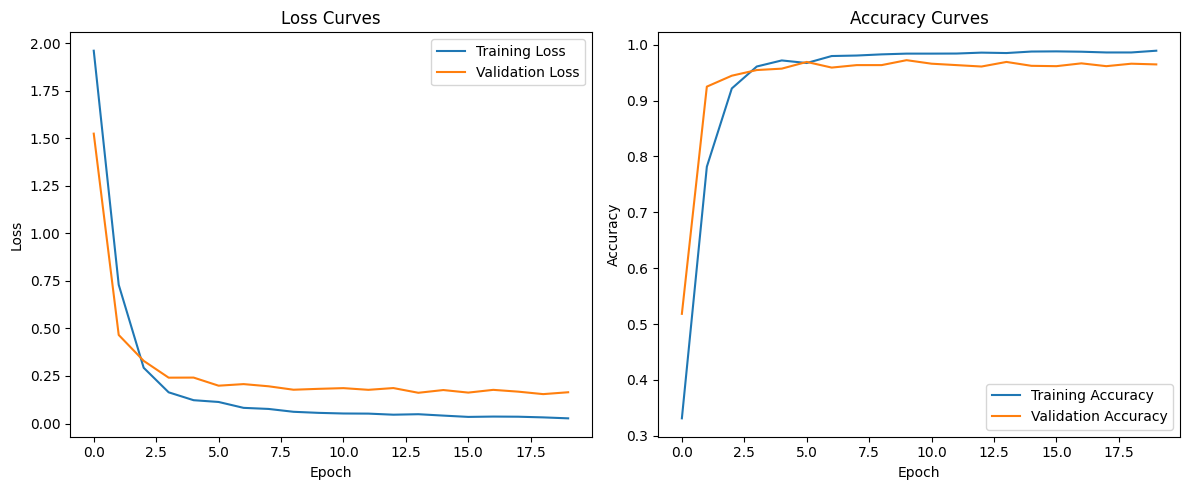

Evaluating model on test data...


Testing: 100%|██████████| 13/13 [00:01<00:00,  8.09it/s, acc=1.0000]

Test Accuracy: 0.9286

Per-class accuracy:
------------------------------
  Class    |  Accuracy  |  Samples  
------------------------------
    1      | 1.0000 |     90    
    2      | 0.9595 |    148    
    3      | 0.6735 |     98    
    4      | 0.9450 |    109    
    5      | 0.9362 |     94    
    6      | 0.9752 |    121    
    7      | 0.9669 |    121    
    8      | 0.9070 |     43    
    9      | 0.8571 |     91    
    10     | 0.8000 |     45    
    11     | 0.9727 |    110    
    12     | 1.0000 |    135    
Training completed!


In [ ]:
# Visualization functions
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()


# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    print("Evaluating model on test data...")
    correct_by_class = {}
    total_by_class = {}

    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing")
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Track per-class accuracy
            for pred, label in zip(preds, labels):
                label_item = label.item()
                if label_item not in total_by_class:
                    total_by_class[label_item] = 0
                    correct_by_class[label_item] = 0

                total_by_class[label_item] += 1
                if pred == label:
                    correct_by_class[label_item] += 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar with current accuracy
            batch_acc = torch.sum(preds == labels).double() / len(labels)
            pbar.set_postfix(acc=f'{batch_acc:.4f}')

    # Overall accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Test Accuracy: {accuracy:.4f}')

    # Per-class accuracy
    print("\nPer-class accuracy:")
    print("-" * 30)
    print(f"{'Class':^10} | {'Accuracy':^10} | {'Samples':^10}")
    print("-" * 30)

    for class_idx in sorted(total_by_class.keys()):
        class_acc = correct_by_class[class_idx] / total_by_class[class_idx]
        print(f"{class_idx:^10} | {class_acc:.4f} | {total_by_class[class_idx]:^10}")

    return all_preds, all_labels


# training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, scheduler=None):
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Print model information at the start
    print(f'Model Architecture:')
    print(model)
    print(f'Total parameters: {sum(p.numel() for p in model.parameters())}')
    print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
    print('-' * 50)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        batch_count = 0

        # Add progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate batch accuracy
            batch_acc = torch.sum(preds == labels.data).double() / inputs.size(0)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            batch_count += 1

            # Update progress bar
            pbar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{batch_acc:.4f}')

            # Print detailed batch statistics every 10 batches
            if batch_idx % 10 == 0:
                print(f'  Batch {batch_idx}/{len(train_loader)}: '
                      f'Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Add progress bar for validation
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch_idx, (inputs, labels) in enumerate(pbar):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Calculate batch accuracy
                batch_acc = torch.sum(preds == labels.data).double() / inputs.size(0)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar
                pbar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{batch_acc:.4f}')

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Update learning rate if using ReduceLROnPlateau scheduler
        if scheduler and isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_acc)
        elif scheduler:
            current_lr = scheduler.get_last_lr()[0]
            scheduler.step()
            print(f'Learning rate: {current_lr:.6f}')

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_traffic_sign_model.pth')
            print(f'New best model saved! Validation accuracy: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(torch.load('best_traffic_sign_model.pth'))

    return model, train_losses, val_losses, train_accs, val_accs

# Run the full training pipeline
def start_train():
    # Parameters
    batch_size = BATCH_SIZE
    num_epochs = NUM_EPOCHS
    num_classes = NUM_CLASSES
    learning_rate = 0.0001

    print(f"Training Configuration:")
    print(f"----------------------")
    print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
    print(f"Batch Size: {batch_size}")
    print(f"Epochs: {num_epochs}")
    print(f"Classes: {num_classes}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Device: {device}")
    print(f"----------------------")

    # Data directories
    data_root = '/content/Dataset'

    # Get transforms
    train_transform = val_transform = get_transform()

    # Create datasets
    train_dataset = TrafficSignDataset(
        'train',
        root_dir=os.path.join(data_root, 'train'),
        transform=train_transform
    )

    val_dataset = TrafficSignDataset(
        'valid',
        root_dir=os.path.join(data_root, 'valid'),
        transform=val_transform
    )

    test_dataset = TrafficSignDataset(
        'test',
        root_dir=os.path.join(data_root, 'test'),
        transform=val_transform
    )

    print(f"\nDataset Information:")
    print(f"-------------------")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")
    print(f"Class mapping: {class_to_idx}")
    print(f"-------------------")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize model - choose one of the following:

    model = SimpleTrafficSignNet(num_classes=num_classes)
    model = model.to(device)

    # Loss function and optimizer with weight decay
    LR = 0.0001                                     # Learning rate
    L2_LAMBDA = 0.0001                              # Lambda for l2 regularization
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_LAMBDA)

    # Learning rate scheduler - use ReduceLROnPlateau for adaptive adjustment
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    # Train model
    print("\nStarting training...")
    print("=" * 50)
    start_time = time.time()

    model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        num_epochs=num_epochs, scheduler=scheduler
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    print("=" * 50)

    # Plot training curves
    plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    # Evaluate on test set
    evaluate_model(model, test_loader)

    print("Training completed!")

start_train()

## **Backup to Google Drive**

In [ ]:
!cp best_traffic_sign_model.pth /content/drive/MyDrive/ECE-653/best_traffic_sign_model.pth
!cp training_curves.png /content/drive/MyDrive/ECE-653/training_curves.png

## **(Inference) Test the model**

In [ ]:
def load_model(model_path, num_classes=13):
    model = SimpleTrafficSignNet(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

model = load_model('best_traffic_sign_model.pth')

<ipython-input-21-d51038d1d749>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


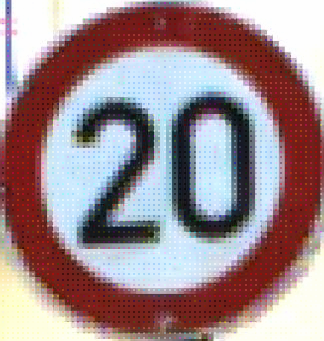

<ipython-input-22-77419ace436e>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x_in, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)


Predicted class: Speed Limit 20
Confidence: 75.35%


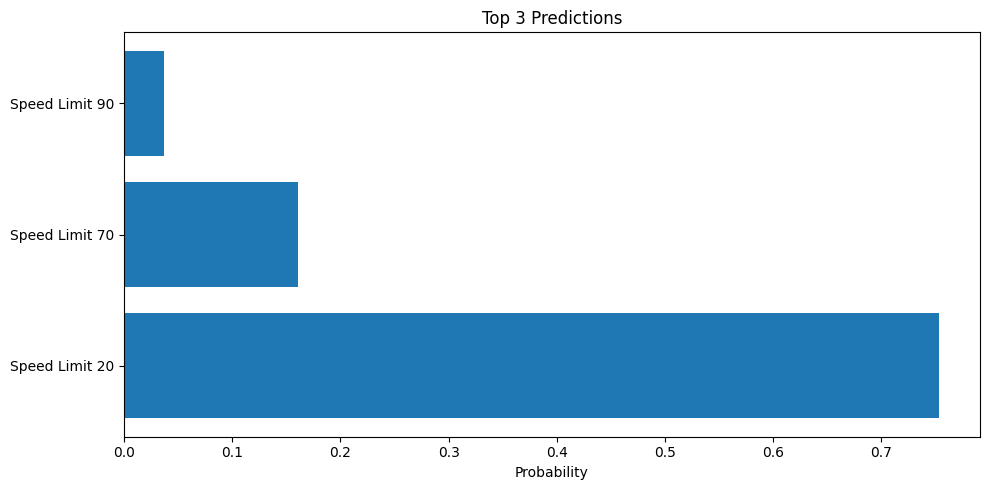

prediction : Speed Limit 20 , conf: 75.35454630851746 %


In [ ]:
def infer(model, cv_image):
    # Set model to evaluation mode
    cv2_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(cv2_image_rgb)
    transform = transforms.ToTensor()

    image_tensor = transform(image)
    image_tensor = image_tensor.permute(1, 2, 0)

    image_tensor = image_tensor.to(device)
    model = model.to(device)

    return predict(model, image_tensor)

# This predict function will be also used by adversarial attacks!
def predict(model, x_in):
    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        # Get current image dimensions
        h, w, c = x_in.shape

        # Convert numpy to tensor and add batch dimension
        x_tensor = torch.tensor(x_in, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        if torch.any(x_tensor > 1.0):
            x_tensor = x_tensor / 255.0

        # Resize to model input size if needed
        if h != IMAGE_SIZE or w != IMAGE_SIZE:
            x_tensor = F.interpolate(x_tensor, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

        outputs = model(x_tensor)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        prediction = outputs.argmax(dim=1).cpu().numpy()[0]


    return prediction, probabilities.squeeze().cpu().numpy()

def predict_class_only(model, x_in):
    prediction, _ = predict(model, x_in)
    return prediction

# Function to display prediction results
def display_prediction(predicted_class, probabilities):
    """
    Display the prediction results

    Args:
        predicted_class: Index of the predicted class
        probabilities: Probabilities for each class
    """
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {probabilities[predicted_class]*100:.2f}%")

    # Display top 3 predictions
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    plt.figure(figsize=(10, 5))
    plt.barh([class_names[i] for i in top3_indices],
             [probabilities[i] for i in top3_indices])
    plt.xlabel('Probability')
    plt.title('Top 3 Predictions')
    plt.tight_layout()
    plt.show()

def crop_with_custom_model_cv2(cv_image):
  # Will be implemented later!
  pass

def perform_inference(model, cv_image, should_crop=False, display_pred=False):
    if should_crop:
      cv_image = crop_with_custom_model_cv2(cv_image)
      if cv_image is None:
          print("Nothing detected.")
          return None, None

    # Perform inference
    predicted_class, probabilities = infer(model, cv_image)

    if display_pred:
      display_prediction(predicted_class, probabilities)

    return predicted_class, probabilities


img = cv2.imread("sample.png")
cv2_imshow(img)
predicted_class, probabilities = perform_inference(model, img, should_crop=False, display_pred=True)

if predicted_class is not None and probabilities is not None:
  print(f'prediction : {class_names[predicted_class]}', ',' , f'conf: {probabilities[predicted_class]*100} %')